In [37]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import torch
import seaborn as sns
plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "text.usetex": True  
    })

import utils as u

In [3]:
df = pd.read_csv('cordis_v1.csv')

In [13]:
df.shape

(37991, 10)

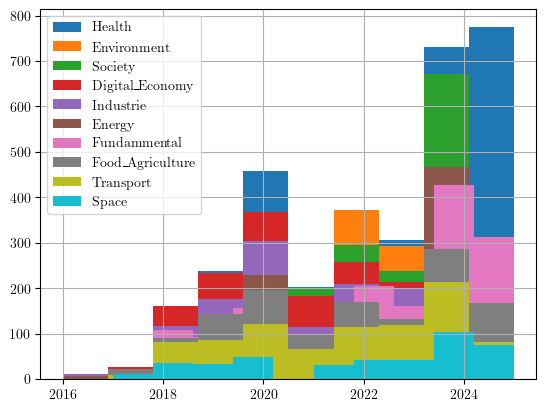

In [38]:
domains = df["Domain"].value_counts()
for domain in domains.index:
    df[df["Domain"]==domain]["year"].hist(label=domain)
plt.legend()
plt.show()

In [ ]:
row = df.loc[0]

print(row)

# print(row["title"])
# print(row["teaser"])
# print(row["body"])
# print(row["keywords"])

Unnamed: 0                                                             0
language                                                              en
id                     182009-smart-grid-redirects-computing-power-to...
title                  Smart grid redirects computing power to heat h...
teaser                 EU-funded researchers have developed a decentr...
body                   The EU-funded project can benefit end users by...
keywords               EeHPC, high performance computing, HPC, Qarnot...
contentCreationDate                                  2016-05-05 15:53:11
Domain                                                   Digital_Economy
year                                                                2016
Name: 0, dtype: object
Smart grid redirects computing power to heat homes
EU-funded researchers have developed a decentralised High Performance Computing grid that actually uses calculations to heat houses and businesses.
The EU-funded project can benefit end users by h

In [30]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Mots-clés (préencodés une seule fois)
# climate_keywords = [
#     "climate change", "global warming", "carbon emissions", "greenhouse gases",
#     "climate adaptation", "climate mitigation", "net zero", "decarbonisation",
#     "resilience to climate", "sustainability", "climate policy", "Paris Agreement",
#     "climate action", "low-carbon", "energy transition", "climate crisis"
# ]

climate_keywords = [
    "climate change", "global warming", "carbon emissions", "greenhouse gases",
    "climate adaptation", "climate mitigation", "net zero", "decarbonisation",
    "resilience to climate", "sustainability", "climate policy", "Paris Agreement",
    "climate action", "low-carbon", "energy transition", "climate crisis",

    "solar energy", "wind power", "hydropower", "renewables", "clean energy",

    "sea level rise", "extreme weather", "flooding", "drought", "air pollution",

    "ecosystem", "biodiversity", "deforestation", "carbon sink", "nature-based solutions",

    "carbon tax", "green finance", "climate justice", "environmental policy",
    "carbon footprint", "sustainable development", "environmental protection",

    "emissions reduction", "energy efficiency", "circular economy", "climate resilience",
    "climate adaptation strategies", "climate risk", "climate governance"
]


keyword_embeddings = model.encode(climate_keywords, convert_to_tensor=True)

df = df[df["body"].notnull()].copy()
texts = df["body"].astype(str).tolist()

batch_size = 256  
climate_scores = []

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    batch_embeddings = model.encode(batch, convert_to_tensor=True)
    batch_scores = util.cos_sim(batch_embeddings, keyword_embeddings)
    max_scores = torch.max(batch_scores, dim=1).values.cpu().tolist()
    climate_scores.extend(max_scores)

# ST= Sentence Transformer
df["climate_score"] = climate_scores
df["is_climate_related"] = df["climate_score"] >= 0.4


100%|██████████| 69/69 [06:06<00:00,  5.31s/it]


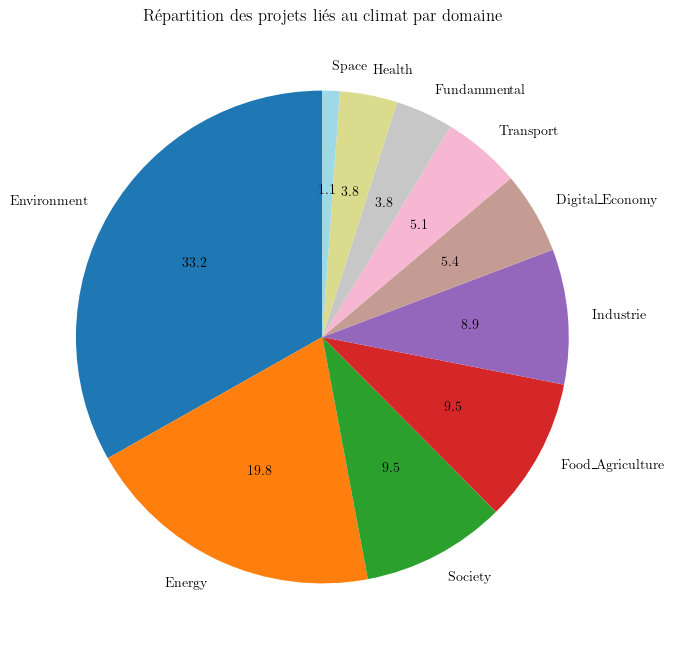

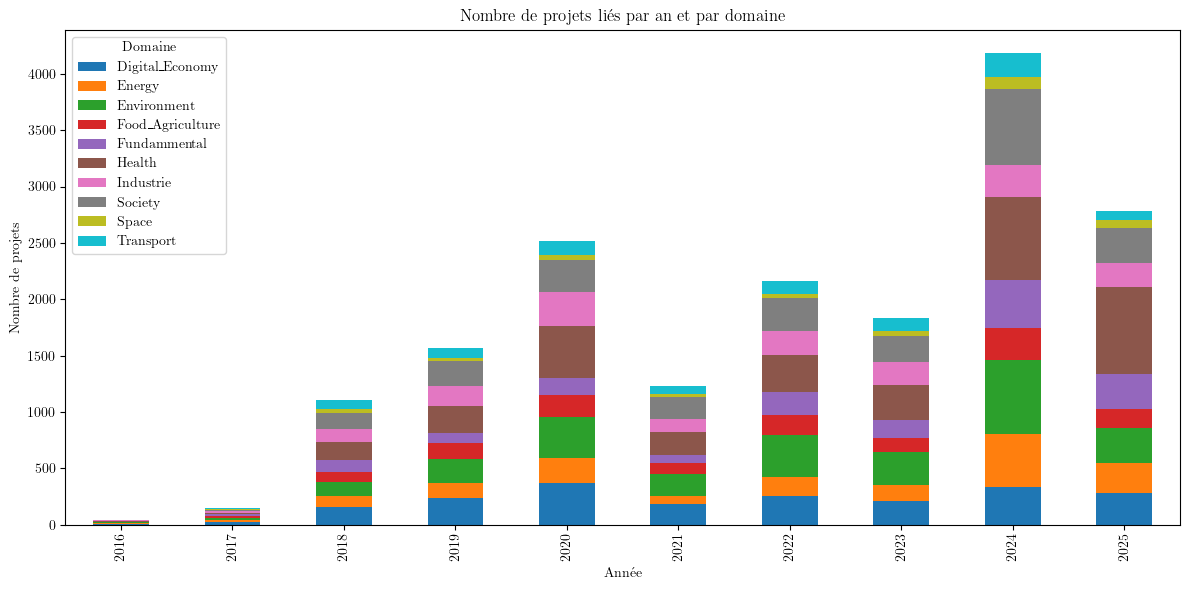

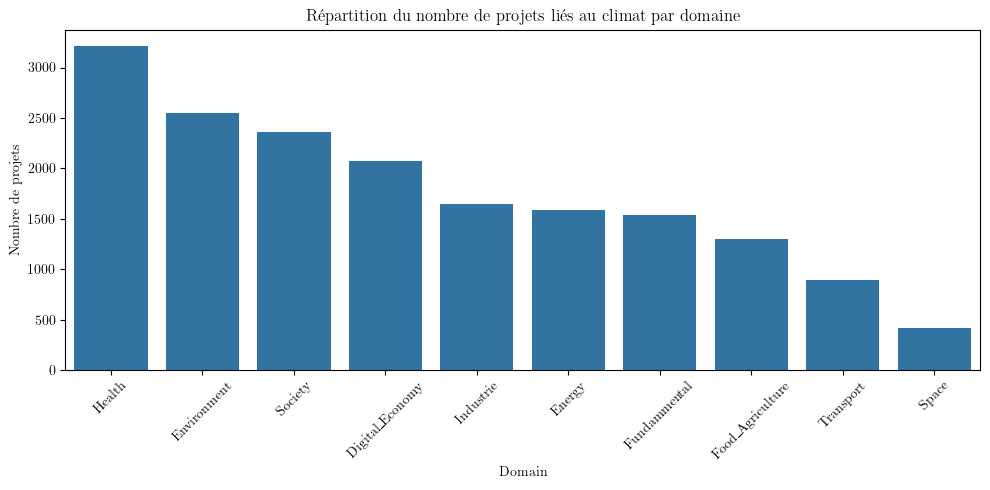

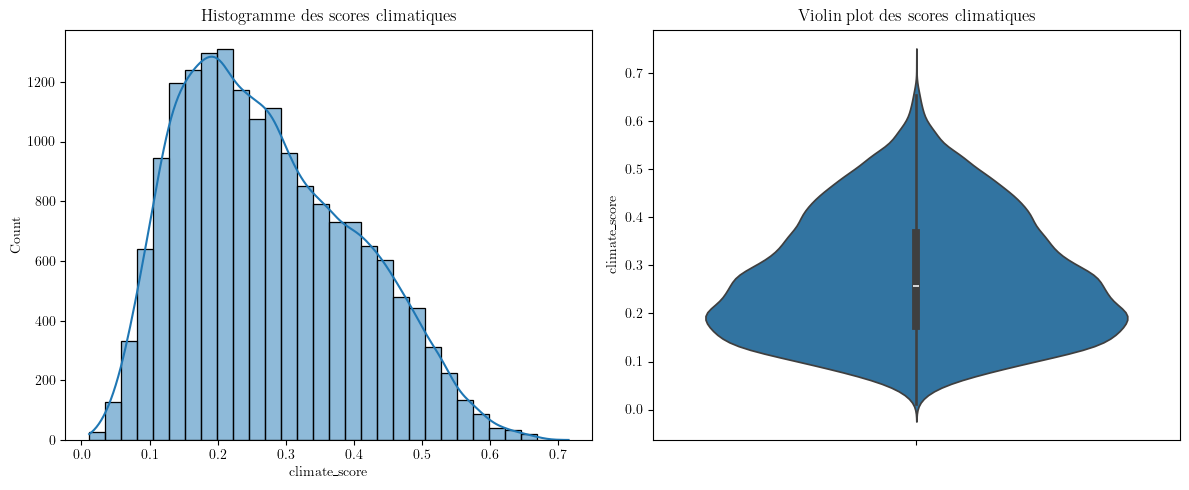

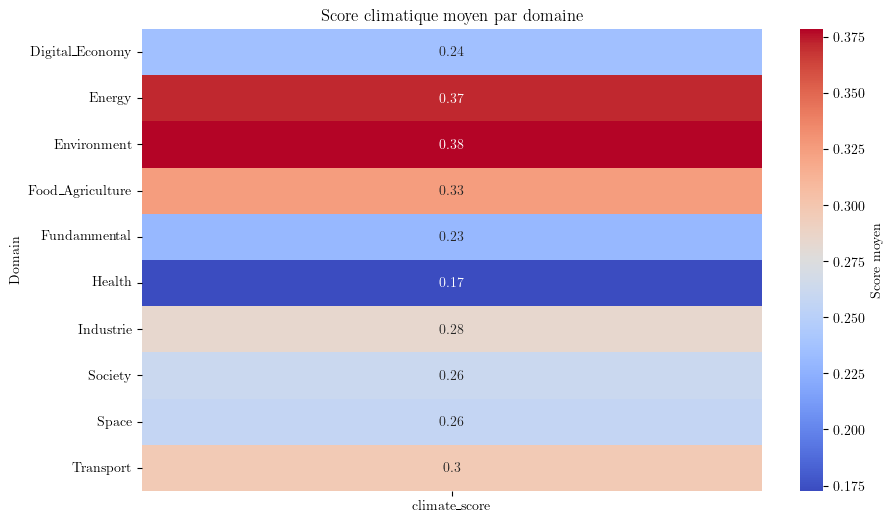

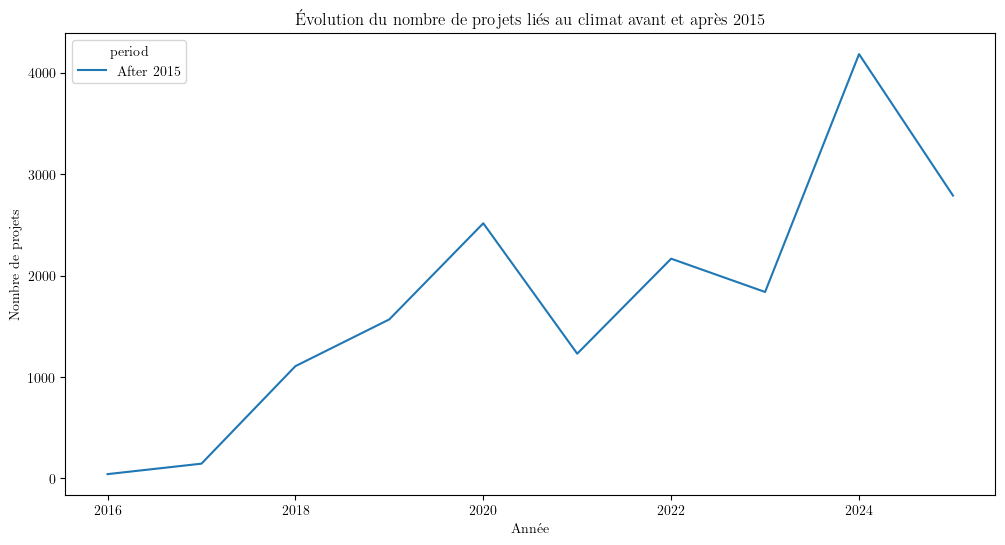

In [43]:
df_climate = df[df['is_climate_related']]

# Compter le nombre de projets par domaine
counts = df_climate['Domain'].value_counts()

# Afficher le camembert
plt.figure(figsize=(8,8))
counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='tab20')
plt.title("Répartition des projets liés au climat par domaine")
plt.ylabel('')  # Pour enlever le label y
plt.show()

# --- 1. Nombre de projets liés par an et par domaine (barres empilées) ---
df_count = df.groupby(['year', 'Domain']).size().reset_index(name='count')
pivot_df = df_count.pivot(index='year', columns='Domain', values='count').fillna(0)

pivot_df.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Nombre de projets liés par an et par domaine')
plt.ylabel('Nombre de projets')
plt.xlabel('Année')
plt.legend(title='Domaine')
plt.tight_layout()
plt.show()

# --- 2. Répartition globale des projets liés au climat par domaine (barres) ---
domain_counts = df['Domain'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=domain_counts.index, y=domain_counts.values)
plt.title('Répartition du nombre de projets liés au climat par domaine')
plt.xticks(rotation=45)
plt.ylabel('Nombre de projets')
plt.tight_layout()
plt.show()

# --- 3. Distribution des scores “climate_score” (histogramme et violin) ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['climate_score'], bins=30, kde=True)
plt.title('Histogramme des scores climatiques')

plt.subplot(1,2,2)
sns.violinplot(y=df['climate_score'])
plt.title('Violin plot des scores climatiques')
plt.tight_layout()
plt.show()


mean_scores = df.groupby('Domain')['climate_score'].mean().reset_index()
mean_scores_pivot = mean_scores.pivot_table(index='Domain', values='climate_score')

plt.figure(figsize=(10,6))
sns.heatmap(mean_scores_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Score moyen'})
plt.title('Score climatique moyen par domaine')
plt.show()


df['period'] = df['year'].apply(lambda y: 'Before 2015' if y < 2015 else 'After 2015')
period_counts = df.groupby(['period', 'year']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.lineplot(data=period_counts, x='year', y='count', hue='period')
plt.title('Évolution du nombre de projets liés au climat avant et après 2015')
plt.ylabel('Nombre de projets')
plt.xlabel('Année')
plt.show()

